# Sentiment140 RNN

This notebook describes how to make an RNN model that can predict the sentiment of a tweet, trained on the sentiment140 dataset.

## Reading the data

It looks like the dataset is in latin-1 encoding even after converting it to utf8 in Notepad++. A simple way to deal with this is just to specify its encoding, and we can figure out how to clear the characters later.


In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("sentiment140_utf8.csv",
                names=cols,
                 encoding='latin-1')

df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Let's map sentiment to 0 and 1, instead of 0 and 4. We also don't need the id, date, query_string and user columns, although they might be useful for other applications such as regression.

In [21]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})


## Data cleaning

Let's look at a couple of tweets to see what kind of cleaning we need to do.

In [31]:
df['pre_clean_len'] = [len(t) for t in df.text]

We're going to need BeautifulSoup to do some of this. 

In [3]:
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'lxml')
print(example1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


In [4]:
import re
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [5]:
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [6]:
df.text[226]

re.sub(r'[^\x00-\x7F]+', ' ', df.text[226])

'Tuesday ll start with reflection  n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [7]:
re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

Looks like we have a couple of things that we need to do.

Above we have tried to fix the following:
1. HTML decoding - removing stuff like &amp etc.
2. @ mentions - removing just the @s, keeping the usernames.
3. URL links - anything with http should be removed. Sometimes people also use www. etc, and we can also handle these cases. Any other type of URL (i.e. claude.ai etc) we probably cannot deal with systematically, so we should opt to ignore them and treat them as noise for now. 
4. Unicode replacement characters - we replace them with spaces for the time being.
5. Hashtags and numbers - here we try to replace them with spaces, keeping the original function intact.

We'll also need a negation dictionary to help us translate some of the contractions, since after data cleaning, words like can't will become can t, which is a significant issue for sentiment analysis (i.e. is can't positive or negative?).

In [23]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    
    # Handle Unicode replacement characters
    lower_case = re.sub(r'[^\x00-\x7F]+', ' ', lower_case)
    
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessary white spaces,
    # I will tokenize and join together to remove unnecessary white spaces
    words = [x for x in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [24]:
%%time
print("Cleaning the tweets...\n")

clean_tweet_texts = []
for i in range(0, len(df)):
    if (i+1) % 100000 == 0:
        print("Tweets %d of %d has been processed" % (i+1, len(df)))
    clean_tweet_texts.append(tweet_cleaner_updated(df['text'][i]))

Cleaning the tweets...


C:\Users\calyc\AppData\Local\Temp\ipykernel_27104\463296673.py:64: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


Tweets 100000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 300000 of 1600000 has been processed
Tweets 400000 of 1600000 has been processed
Tweets 500000 of 1600000 has been processed
Tweets 600000 of 1600000 has been processed
Tweets 700000 of 1600000 has been processed
Tweets 800000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 1000000 of 1600000 has been processed
Tweets 1100000 of 1600000 has been processed
Tweets 1200000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1600000 of 1600000 has been processed
CPU times: total: 1min 52s
Wall time: 2min 6s


### Visualising our clean data

In [25]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')

In [26]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text,target
0,awww that is bummer you shoulda got david carr...,0
1,is upset that he cannot update his facebook by...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it is not behaving at all am mad why am her...,0


Some tweets will only have links etc, which means after data cleaning they will become NAs or nulls. We should drop them before proceeding with data analysis.

In [27]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596044 entries, 0 to 1596043
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596044 non-null  object
 1   target  1596044 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


Now that data cleaning has been completed, let's first do some basic visualisation tasks. We can proceed by first trying out the controversial WordCloud.

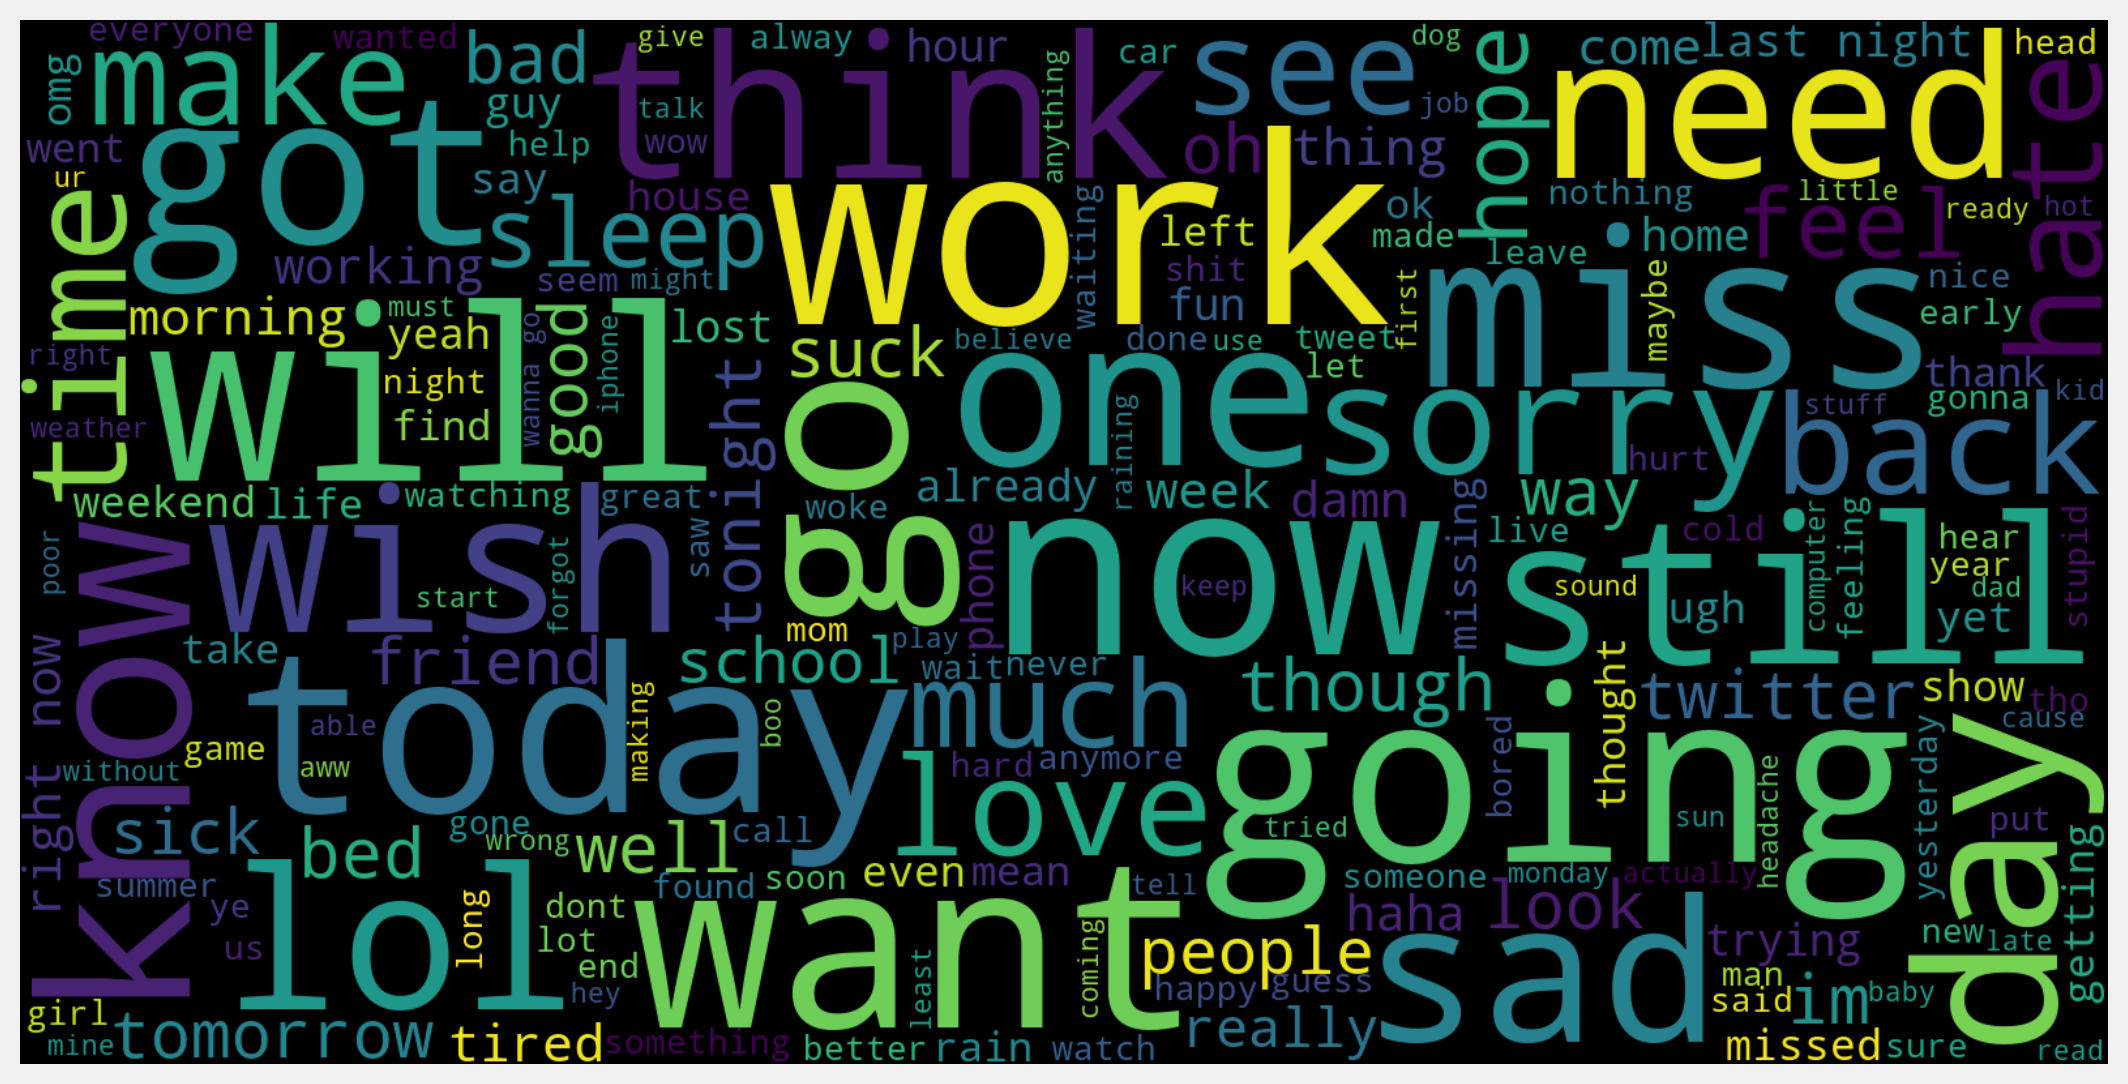

In [13]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



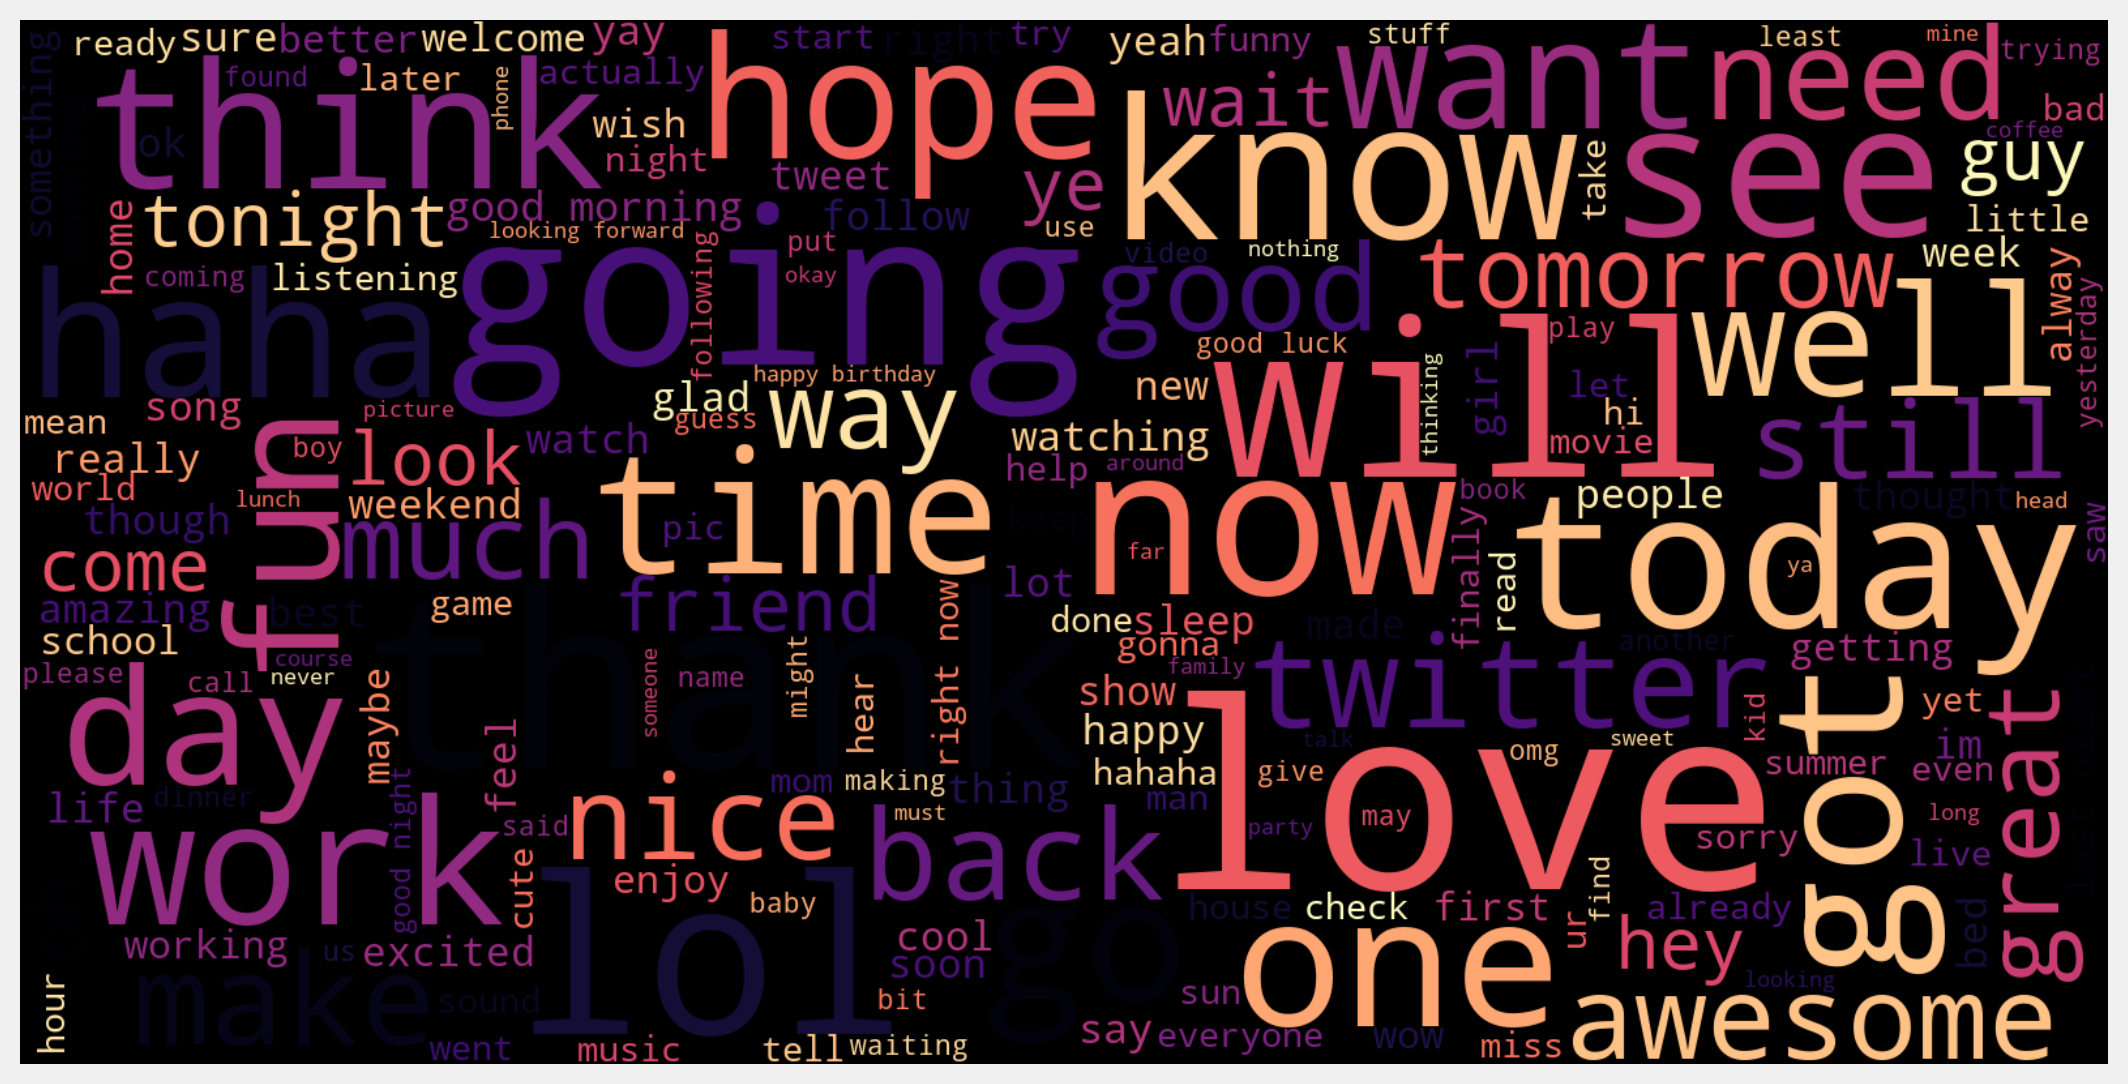

In [28]:
pos_tweets = my_df[my_df.target == 1]

pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



Before trying out RNN, we need some term frequency data to work with for other methods. We can try using a count vectorizer to calculate term frequencies.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=80000)
cvec.fit(my_df.text)

CountVectorizer(max_features=80000, stop_words='english')

In [32]:
len(cvec.get_feature_names_out())

80000

We can directly obtain the term frequencies as below:

In [33]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()

In [34]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

term_freq_df

,negative,positive,total
aa,160,92,252
aaa,93,54,147
aaaa,45,29,74
aaaaa,26,12,38
aaaaaa,16,12,28
...,...,...,...
zzzzzzzzzzzzzzzzz,2,1,3
zzzzzzzzzzzzzzzzzz,2,1,3
zzzzzzzzzzzzzzzzzzz,2,1,3
zzzzzzzzzzzzzzzzzzzzzzzzzzz,1,2,3


With this frequency table, we can then try to see how the words follow Zipf's Law.

C:\Users\calyc\AppData\Local\Temp\ipykernel_27104\3851007787.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frequencies = counts[indices]
C:\Users\calyc\AppData\Local\Temp\ipykernel_27104\3851007787.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
C:\Users\calyc\AppData\Local\Temp\ipykernel_27104\3851007787.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dummy =

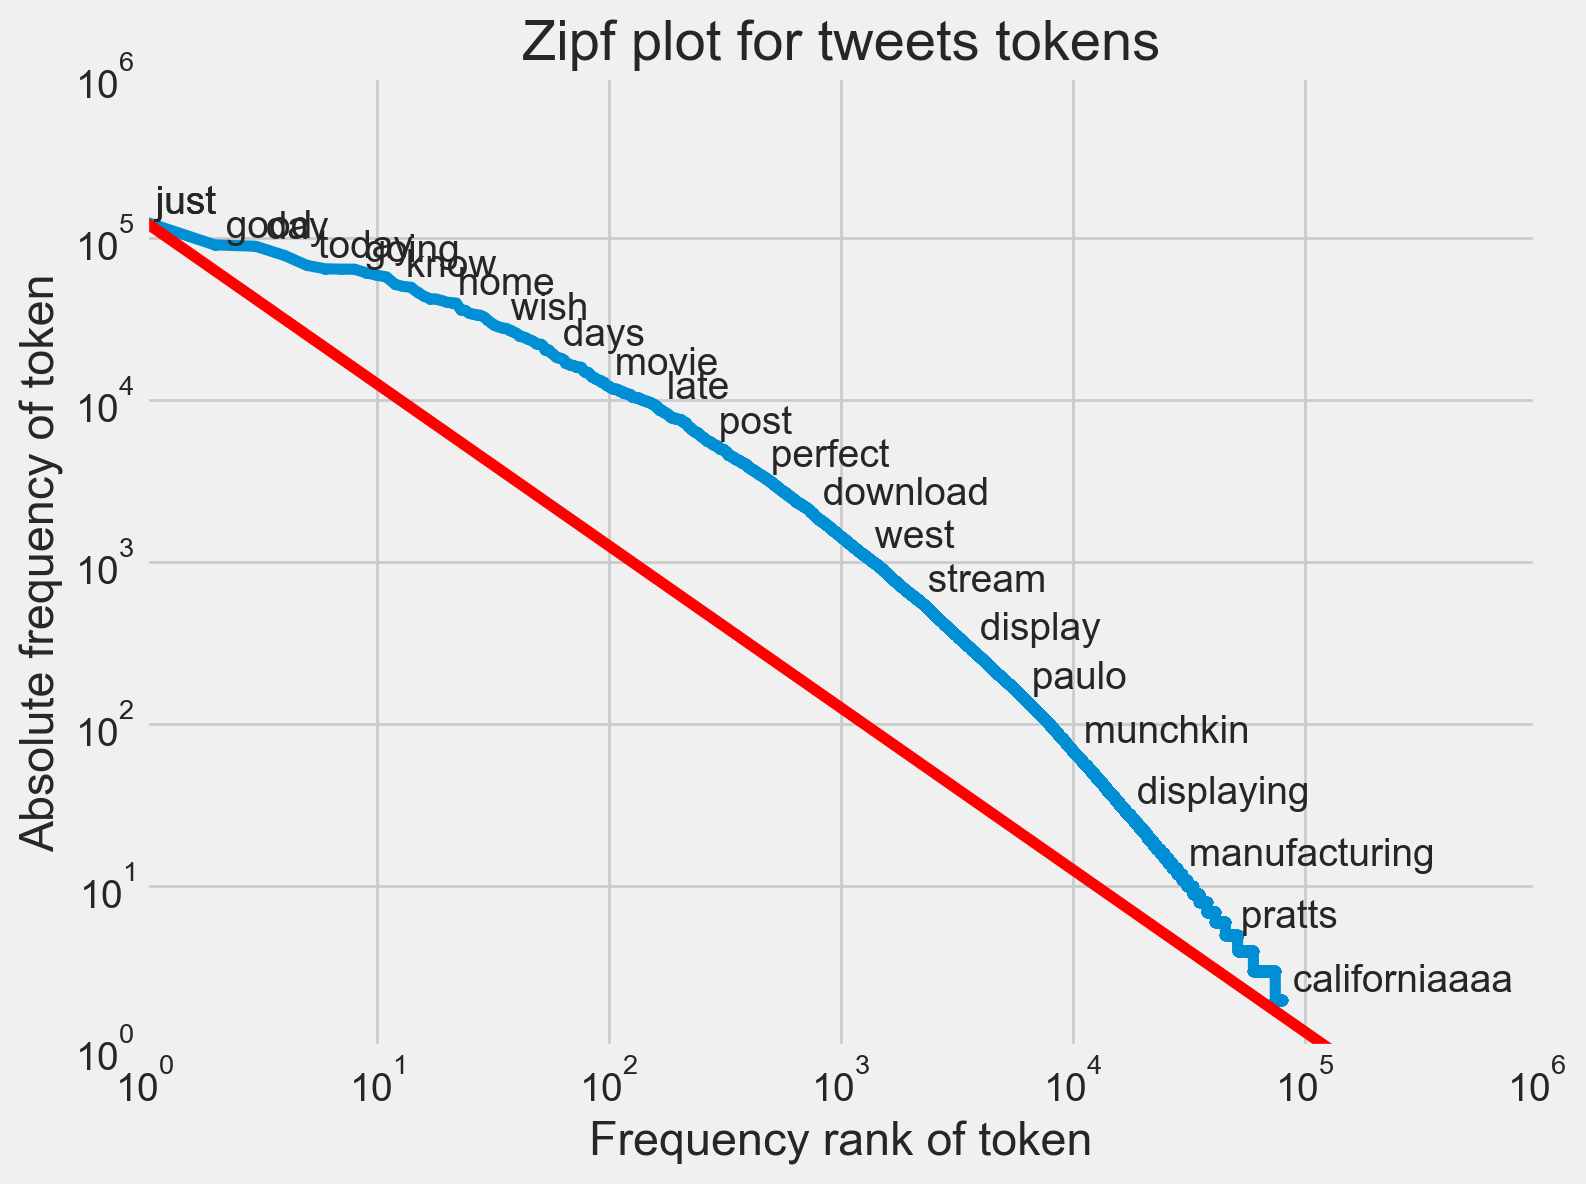

In [35]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

The most frequent words that appear don't seem to directly convey meaningful information about sentimentality of the tweet. What we can do is to check the frequency of which a word appears more often in one class or another (e.g. rate). A second alternative might be to create a "neutral" class, but we can do that in a later exercise.

Let's see if we can create different frequency functions to compare between the frequency of positive versus negative word tokens.

In [36]:
term_freq_df2 = term_freq_df

In [37]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,0,3,3,1.0
showbread,0,3,3,1.0
kewler,0,2,2,1.0
shiply,0,2,2,1.0
kewlll,0,2,2,1.0
keylime,0,2,2,1.0
shinra,0,5,5,1.0
keyrings,0,3,3,1.0
keysha,0,3,3,1.0
bloodlines,0,3,3,1.0


In [38]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
just,64004,62944,126948,0.495825,0.013280
good,29209,62118,91327,0.680171,0.013106
day,41374,48186,89560,0.538030,0.010166
love,16990,47694,64684,0.737338,0.010063
like,41050,37520,78570,0.477536,0.007916
lol,23123,36118,59241,0.609679,0.007620
thanks,5768,34375,40143,0.856314,0.007253
going,33689,30939,64628,0.478724,0.006528
time,27526,30432,57958,0.525070,0.006421
today,38116,30100,68216,0.441245,0.006351


In [39]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])
                                                                   if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
just,64004,62944,126948,0.495825,0.013280,0.025867
good,29209,62118,91327,0.680171,0.013106,0.025716
day,41374,48186,89560,0.538030,0.010166,0.019956
love,16990,47694,64684,0.737338,0.010063,0.019854
like,41050,37520,78570,0.477536,0.007916,0.015574
lol,23123,36118,59241,0.609679,0.007620,0.015052
thanks,5768,34375,40143,0.856314,0.007253,0.014383
going,33689,30939,64628,0.478724,0.006528,0.012880
time,27526,30432,57958,0.525070,0.006421,0.012686
today,38116,30100,68216,0.441245,0.006351,0.012521


In [40]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
followfriday,169,2731,2900,0.941724,0.000576,0.001152,0.947821,0.999940,0.973183
welcome,620,6702,7322,0.915324,0.001414,0.002824,0.936133,1.000000,0.967013
vip,161,1632,1793,0.910206,0.000344,0.000688,0.933648,0.988189,0.960144
congratulations,101,1410,1511,0.933157,0.000297,0.000595,0.944230,0.974038,0.958902
congrats,457,3312,3769,0.878748,0.000699,0.001396,0.916697,0.999999,0.956538
smile,388,2745,3133,0.876157,0.000579,0.001158,0.915168,0.999944,0.955680
thank,2282,15736,18018,0.873349,0.003320,0.006615,0.913486,1.000000,0.954787
proud,312,1933,2245,0.861024,0.000408,0.000815,0.905812,0.996495,0.948992
thanks,5768,34375,40143,0.856314,0.007253,0.014383,0.902750,1.000000,0.948890
thx,428,2198,2626,0.837014,0.000464,0.000927,0.889441,0.998957,0.941023


Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

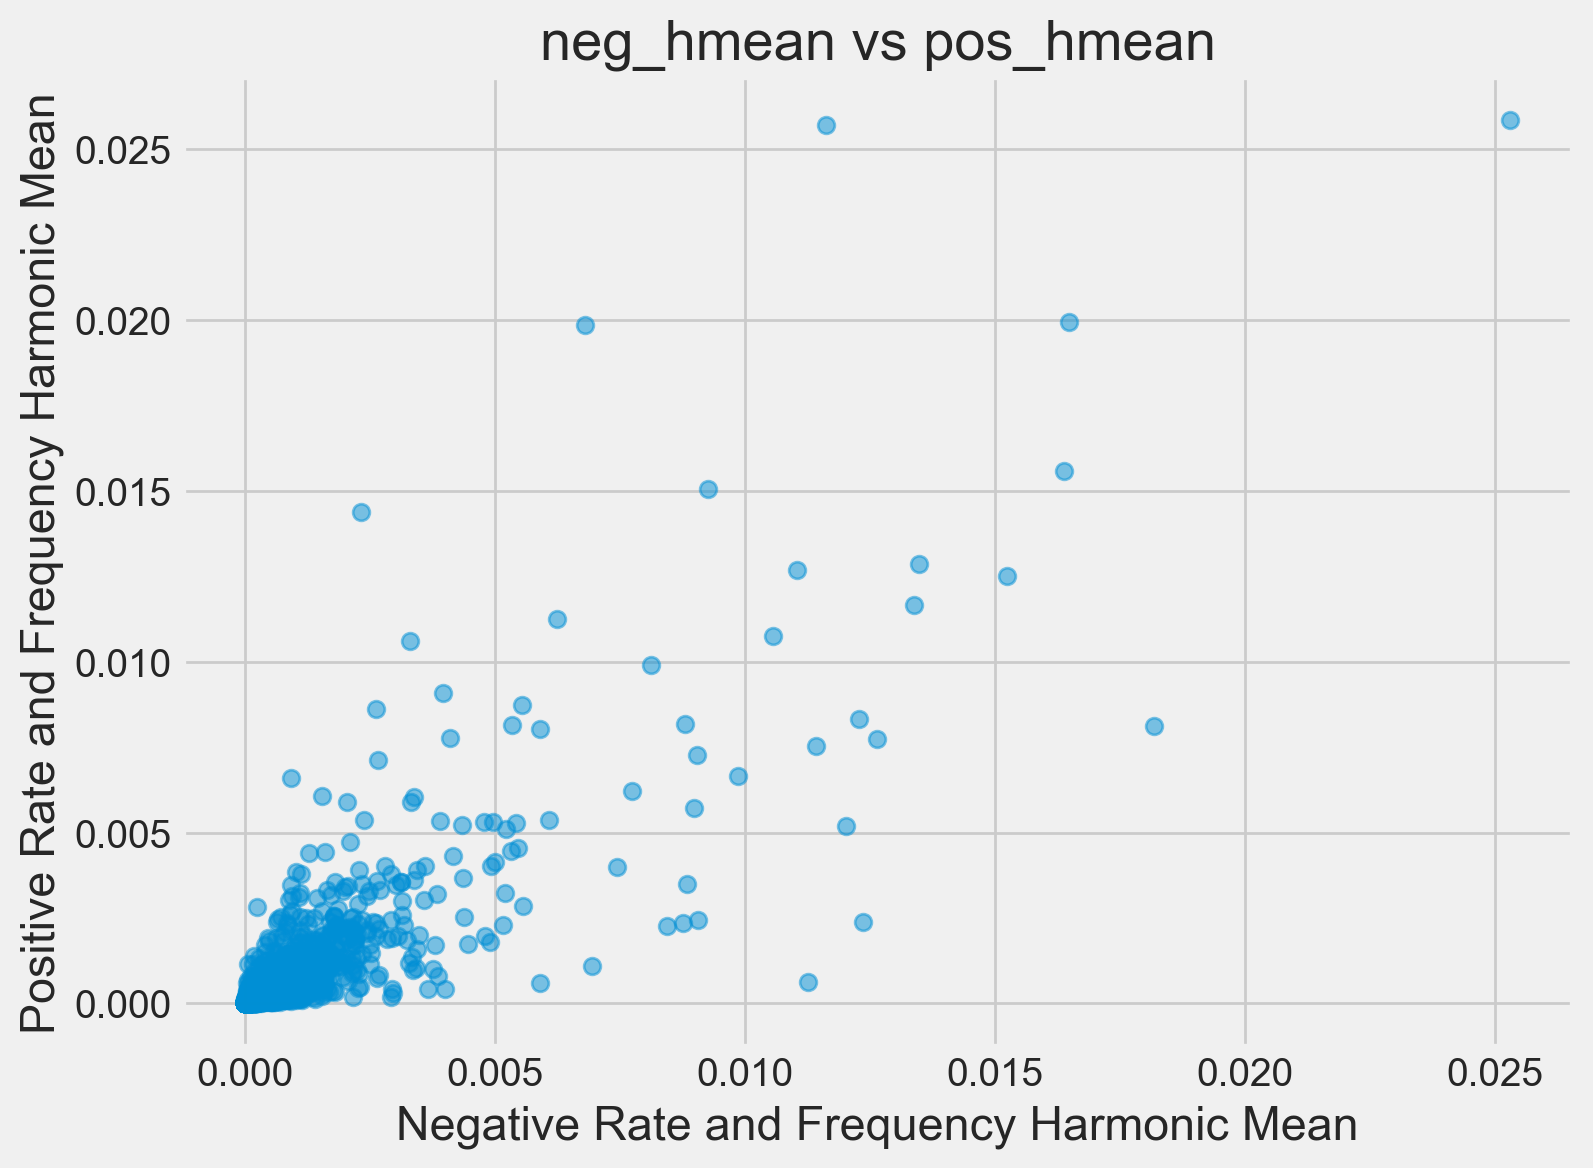

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Now, we can proceed to training the model. We first get a couple of baselines, which are the Zero rule and TextBlob.

In [42]:
x = my_df.text
y = my_df.target

from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1564123 entries with 50.01% negative, 49.99% positive
Validation set has total 15960 entries with 50.30% negative, 49.70% positive
Test set has total 15961 entries with 49.33% negative, 50.67% positive


In [43]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [44]:
%%time
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

CPU times: total: 812 ms
Wall time: 1.33 s


In [45]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1, 0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive', 'predicted_negative'])
print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred) * 100))
print("-" * 80)
print("Confusion Matrix\n")
print(confusion)
print("-" * 80)
print("Classification Report\n")
print(classification_report(y_validation, tbpred))

Accuracy Score: 61.13%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7153                 779
negative                5425                2603
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.77      0.32      0.46      8028
           1       0.57      0.90      0.70      7932

    accuracy                           0.61     15960
   macro avg       0.67      0.61      0.58     15960
weighted avg       0.67      0.61      0.58     15960


To use text in ML, we can use a bag-of-words approach. Given the large amount of vocabulary, we may first need to try a couple of different approaches before we know what the optimal number of features are.

To try logistic regression, we should avoid using the default lbfgs solver, since it doesn't work so well for large datasets and may fail to converge. The improved Stochastic Average Gradient descent solver should perform a bit better. The default 100 iterations also wouldn't be enough, so let's try 1000 iterations.

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [47]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test) * 1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test) * 1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test) * 1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy * 100))
    print("accuracy score: {0:.2f}%".format(accuracy * 100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy - null_accuracy) * 100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy - accuracy) * 100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-" * 80)
    return accuracy, train_test_time

In [55]:
cvec = CountVectorizer()
lr = LogisticRegression(solver='saga', max_iter=1000)
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy, tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n, nfeature_accuracy, tt_time))
    return result

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test) * 1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test) * 1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test) * 1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0, 1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                             columns=['predicted_negative', 'predicted_positive'])
    print("null accuracy: {0:.2f}%".format(null_accuracy * 100))
    print("accuracy score: {0:.2f}%".format(accuracy * 100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy - null_accuracy) * 100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy - accuracy) * 100))
    print("-" * 80)
    print("Confusion Matrix\n")
    print(confusion)
    print("-" * 80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

Let's compare between unigram and trigram approaches.

In [56]:
%%time
ug_cvec = CountVectorizer(max_features=80000)
ug_pipeline = Pipeline([
        ('vectorizer', ug_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(ug_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 50.30%
accuracy score: 80.06%
model is 29.76% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6295                1733
positive                1449                6483
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.78      0.80      8028
    positive       0.79      0.82      0.80      7932

    accuracy                           0.80     15960
   macro avg       0.80      0.80      0.80     15960
weighted avg       0.80      0.80      0.80     15960

CPU times: total: 6min 19s
Wall time: 8min 3s


Even with 1000 iterations, a trigram approach wouldn't be able to converge, although the findings aren't all that different from a unigram approach. To save time I would opt to not re-run this, but those who are interested can try increasing the number of iterations for the logistic regression solver.

In [57]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

C:\Users\calyc\PycharmProjects\sentiment_analysis\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


null accuracy: 50.30%
accuracy score: 81.78%
model is 31.48% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6389                1639
positive                1269                6663
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.80      0.81      8028
    positive       0.80      0.84      0.82      7932

    accuracy                           0.82     15960
   macro avg       0.82      0.82      0.82     15960
weighted avg       0.82      0.82      0.82     15960

CPU times: total: 10min 20s
Wall time: 12min 34s


## RNN Model

Next, let's experiment with using PyTorch on the same training and validation sets.

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader


We repeat some of the code from earlier so that it's simpler for us to just copy-paste this part to a .py script. You do not have to run the code below if you've already run it earlier in the notebook!

In [4]:
# Convert text column to string type

csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv, index_col=0)
my_df.head()
my_df.dropna(inplace=True)
my_df.reset_index(drop=True, inplace=True)
my_df.info()

x = my_df.text
y = my_df.target

from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596041 non-null  object
 1   target  1596041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB
Number of samples in my_df: 1596041
Length of train_data: 1564120
Length of valid_data: 15960
Length of test_data: 15961


Here we continue with code specific to the RNN model fit.

In [59]:
# Create train, validation, and test datasets
train_data = list(zip(x_train, y_train))
valid_data = list(zip(x_validation, y_validation))
test_data = list(zip(x_test, y_test))

print("Number of samples in my_df:", len(my_df))  
print("Length of train_data:", len(train_data))
print("Length of valid_data:", len(valid_data))
print("Length of test_data:", len(test_data))

Number of samples in my_df: 1596044
Length of train_data: 1564123
Length of valid_data: 15960
Length of test_data: 15961


### Tokenizer

For logistic regression, we used a bag-of-words approach. For RNN (and ML or non-parametric learning approaches), we can use the SpaCy approach, combined with the use of torchtext's build_vocab_from_iterator. The resulting vocabulary can be used to convert text data into integer sequences, which can be fed into neural network models for tasks like text classification or language modeling.

In [60]:
# Define the tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# Create vocabulary
def yield_tokens(data_iter):
    for text, _ in data_iter:  # Unpack the tuple
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Create data iterators
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [61]:
def collate_batch(batch):
    label_list, text_list = [], []
    for (_text, _label) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(vocab(tokenizer(_text)), dtype=torch.int64)
        text_list.append(processed_text)

    label_list = torch.tensor(label_list, dtype=torch.float32) 
    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    return label_list.to(device), text_list.to(device)

Because I have a dedicated GPU, I opt for a larger batch size of 256. If you're doing it on the CPU, a smaller batch size might be more manageable.

In [65]:
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_data, batch_size=256, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False, collate_fn=collate_batch)

print("Dataloaders created!")   # Check if this message prints
print(len(train_dataloader), len(valid_dataloader), len(test_dataloader)) # Check dataset lengths


Dataloaders created!
6110 63 63


### Model specification

Because we use BCELoss as the criterion, we need to apply a sigmoid function to the output of the model. This version of BCELoss expects the input to be a tensor of probabilities (values between 0 and 1).

If you instead want to use nn.BCEWithLogitsLoss: This version of BCELoss combines the sigmoid operation and the binary cross-entropy loss in a single function. It expects the input to be raw logits (unnormalized scores) instead of probabilities. If you are using nn.BCEWithLogitsLoss, you don't need to apply the sigmoid function explicitly. In this case, you can remove the line out = torch.sigmoid(out) from your code.

We can start with 2 layers and see how the results are before we decide if we want any more layers or if we need to go back to 1 to prevent overfitting.

In [66]:
# Define the model
class RNNBinaryClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)  

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = hidden[-1]
        out = self.fc(hidden)
        out = torch.sigmoid(out)
        return out[:, 1]

# Instantiate the model
input_dim = len(vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = 2  
num_layers = 2  # Example; adjust as needed  

model = RNNBinaryClassifier(input_dim, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

### Training

We can start with 5 epochs, and slowly see if we need any more to train the model.

In [67]:
from tqdm import tqdm

# Train the model
epochs = 5
for epoch in range(epochs):
    train_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    for batch in progress_bar:
        labels, texts = batch
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        progress_bar.set_postfix({"Training Loss": float(train_loss / (progress_bar.n + 1))})

Epoch 5/5: 100%|██████████| 6110/6110 [01:21<00:00, 75.00batch/s, Training Loss=0.305]


We could probably increase the batch size further, since my GPU is only pulling 123W on average during this process.

+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
| 41%   40C    P2            123W /  450W |    2848MiB /  24564MiB |     40%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+

But this is a reasonable speed for 5 epochs, so I'll leave it as-is.

In [68]:
torch.save(model, "sentiment140_2.pt")


### Model evaluation

We can now evaluate our RNN model on the validation set.

In [69]:
# Evaluate on the validation set
model.eval()
with torch.no_grad():
    valid_preds = []
    for labels, texts in valid_dataloader:
        predictions = model(texts).squeeze()
        valid_preds.append(predictions.cpu().numpy())

valid_preds = np.concatenate(valid_preds)

In [70]:
# Get the text, true labels from the validation set
valid_texts = [text for text, _ in valid_data]
valid_labels = [label for _, label in valid_data]

# Create a DataFrame with predicted probabilities, true labels, and original texts
valid_results = pd.DataFrame({
    'text': valid_texts,
    'pred_prob': valid_preds,
    'true_label': valid_labels
})

valid_results

,text,pred_prob,true_label
0,happy saturday everyone whether you are on my ...,0.986708,1
1,happy birthday to bre and danny,0.993084,1
2,the weather is good here too and am off to wor...,0.468771,0
3,no revision tonight yay tomorrow starts again,0.609385,0
4,ran over snake foot black racer poor creature,0.025429,0
...,...,...,...
15955,have safe flight home looking forward to catch...,0.983850,1
15956,ouch cnn reports myspace has flat lined and co...,0.492534,1
15957,just call me captain bread maker,0.933382,1
15958,am finally on twitter and on the coven online,0.976899,1


In [71]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

valid_results['pred_label'] = (valid_results['pred_prob'] > 0.5).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(valid_results['true_label'], valid_results['pred_label'])
f1 = f1_score(valid_results['true_label'], valid_results['pred_label'])
precision = precision_score(valid_results['true_label'], valid_results['pred_label'])
recall = recall_score(valid_results['true_label'], valid_results['pred_label'])

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1-Score: {f1:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")

Validation Accuracy: 0.8302
Validation F1-Score: 0.8283
Validation Precision: 0.8324
Validation Recall: 0.8243


We get scores pretty similar to the logistic regression that we ran earlier. Sometimes, using a more complex approach like RNN doesn't mean you'll always get better results than parametic learning approaches, and it's important to keep this in mind.

Now, let's play around with our model, and see if we can get it to predict the sentiment of some new text that we have.

Again, if you already have run this code earlier, you don't need to run it again.

In [72]:
import torch

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model on the desired device
sentiment140 = torch.load('sentiment140_2.pt', map_location=device)
sentiment140.eval()  # Set the model to evaluation mode

# Define the tokenizer and vocabulary
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Move the vocabulary to the device
vocab = vocab.to(device)


In [108]:
# Function to preprocess and tokenize text
def preprocess_text(text):
    tokenized_text = torch.tensor(vocab(tokenizer(text)), dtype=torch.int64, device=device)
    padded_text = torch.nn.utils.rnn.pad_sequence([tokenized_text], batch_first=True, padding_value=vocab["<unk>"])
    return padded_text

# Function to predict sentiment
def predict_sentiment(text):
    if not text.strip():  # Check if the input text is empty or contains only whitespace
        return 0.5  # Return a default sentiment probability of 0.5 for empty input
    preprocessed_text = preprocess_text(text)
    with torch.no_grad():
        prediction = sentiment140(preprocessed_text).squeeze()
        sentiment_prob = prediction.item()
    return sentiment_prob

In [73]:
# Function to print the sentiment prediction
def print_sentiment_prediction(input_text):
    sentiment_prob = predict_sentiment(input_text)
    print(f"Input text: {input_text}")
    print(f"Sentiment probability (positive): {sentiment_prob:.4f}")
    if sentiment_prob > 0.66:
        print("Predicted sentiment: Positive")
    elif sentiment_prob < 0.33:
        print("Predicted sentiment: Negative")
    else:
        print("Predicted sentiment: Neutral")
    print()

In [74]:
print_sentiment_prediction("This movie was amazing! I loved every second of it.")

Input text: This movie was amazing! I loved every second of it.
Sentiment probability (positive): 0.9880
Predicted sentiment: Positive


In [75]:
print_sentiment_prediction("I had a terrible experience with this product. It was a waste of money.")

Input text: I had a terrible experience with this product. It was a waste of money.
Sentiment probability (positive): 0.0401
Predicted sentiment: Negative


In [76]:
print_sentiment_prediction("This is possibly the worst idea we have ever had haha")

Input text: This is possibly the worst idea we have ever had haha
Sentiment probability (positive): 0.2604
Predicted sentiment: Negative


# SEMTask verification

Our model is trained on just positive and negative sentiments. Can we use it to make predictions about sentiments from a new dataset?

Let's try it out on the SEMeval dataset from 2016.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import glob

path = 'semeval/'
all_files = glob.glob(path + "/semeval*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in all_files:
    df = pd.read_csv(file_, index_col=None, sep='\t', header=None, skiprows=1, names=['sentiment', 'text', 'to_del'])
    list_.append(df.iloc[:,:-1])

df = pd.concat(list_)
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.tail()

,sentiment,text
69509,0,"My 1st & likely last Justin Bieber tweet, but ..."
69510,1,I'm just gonna say it -- a cypher with Big Sea...
69511,1,@13millionplus @chrislhayes Going to see The B...
69512,-1,Not even Syrians think of destroying Israel as...
69513,1,I'll make icons & headers of Lady Gaga from th...


In [3]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [41]:
import unidecode
import re
import spacy

nlp = spacy.load('en_core_web_sm')

def spacy_cleaner(text):
    try:
        # Remove diacritics from the text
        decoded = unidecode.unidecode(text)
    except TypeError:
        # If the input is not a string, return an empty string
        return ""
    
    # Replace apostrophe variations with a standard apostrophe
    apostrophe_handled = re.sub("'", "'", decoded)
    
    # Expand contractions using the contraction_mapping dictionary
    expanded = ' '.join([contraction_mapping.get(t, t) for t in apostrophe_handled.split(" ")])
    
    # Parse the expanded text using spaCy
    doc = nlp(expanded)
    
    final_tokens = []
    for token in doc:
        if token.is_punct or token.is_space or token.like_num or token.like_email or token.like_url:
            # Skip punctuation, whitespace, numbers, emails, and URLs
            continue
        elif token.lemma_ == '-PRON-':
            # Append the original token if it is a pronoun
            final_tokens.append(token.text)
        else:
            # Remove non-alphabetic characters from the token text and append if length > 1
            cleaned_token = re.sub(r'[^a-zA-Z]', '', token.text)
            if len(cleaned_token) > 1:
                final_tokens.append(cleaned_token)
    
    # Join the final tokens into a single string
    cleaned_text = ' '.join(final_tokens)
    
    # Correct repeated characters (e.g., "helllo" -> "hello")
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', cleaned_text)
    
    return spell_corrected


In [42]:
from tqdm import tqdm

df['clean_text'] = [spacy_cleaner(t) for t in tqdm(df.text, total=len(df), unit='texts')]

100%|██████████| 69514/69514 [04:11<00:00, 275.96texts/s]


In [43]:
df.dropna(inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69514 entries, 0 to 69513
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   69514 non-null  int64 
 1   text        69514 non-null  object
 2   clean_text  69514 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [45]:
sentiment_mapping = {-1: 'negative', 0: 'neutral', 1: 'positive'}

df['sentiment_code'] = df['sentiment'].map(sentiment_mapping)

As we did earlier, this is a pretty crude way to get positive versus negative versus neutral classification given that our model is trained purely on positive versus negative sentiments only. We could probably modify the probability thresholds to get better classification scores.

In [115]:
# Function to get the sentiment label
def get_sentiment_label(sentiment_prob):
    if sentiment_prob > 0.66:
        return "positive"
    elif sentiment_prob < 0.33:
        return "negative"
    else:
        return "neutral"

In [116]:
from tqdm import tqdm

# Iterate over the rows of the DataFrame and make predictions
sentiment_probs = []
sentiment_labels = []
for text in tqdm(df['clean_text'], desc='Processing tweets', unit='tweet'):
    sentiment_prob = predict_sentiment(text)
    sentiment_probs.append(sentiment_prob)
    sentiment_label = get_sentiment_label(sentiment_prob)
    sentiment_labels.append(sentiment_label)

# Add the sentiment probability and predicted sentiment as new columns to the DataFrame
df['sentiment_prob'] = sentiment_probs
df['predicted_sentiment'] = sentiment_labels

Processing tweets: 100%|██████████| 69514/69514 [01:19<00:00, 874.01tweet/s] 


In [117]:
selected_columns = ['text', 'sentiment_prob', 'sentiment_code', 'predicted_sentiment']
df_selected = df.loc[:, selected_columns]

In [118]:
df_selected

,text,sentiment_prob,sentiment_code,predicted_sentiment
0,Watching Devil Inside for the 1st time tonight...,0.771234,neutral,positive
1,"@CMPunk Devil Inside , The exorcisism of Emily...",0.435389,neutral,neutral
2,Off to do my vlog. Watching Devil Inside and J...,0.956775,neutral,positive
3,@raykipo take Silver at the Hib cup. Great day...,0.883718,positive,positive
4,@hollyhippo I'm going to blockbuster tomorrow ...,0.552265,neutral,neutral
...,...,...,...,...
69509,"My 1st & likely last Justin Bieber tweet, but ...",0.529746,neutral,neutral
69510,I'm just gonna say it -- a cypher with Big Sea...,0.500435,positive,neutral
69511,@13millionplus @chrislhayes Going to see The B...,0.938407,positive,positive
69512,Not even Syrians think of destroying Israel as...,0.074420,negative,negative


As seen below, none of the metrics are all that good. Could it be because of our 0.66 and 0.33 probability thresholds?

In [119]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(df_selected['sentiment_code'], df_selected['predicted_sentiment'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

    negative       0.39      0.41      0.40     12953
     neutral       0.49      0.28      0.36     31611
    positive       0.46      0.70      0.56     24950

    accuracy                           0.46     69514
   macro avg       0.45      0.46      0.44     69514
weighted avg       0.46      0.46      0.44     69514


Let's try thresholds that are a little tighter: 0.8 and 0.2 respectively.

In [120]:
# Function to get the sentiment label
def get_sentiment_label2(sentiment_prob):
    if sentiment_prob > 0.8:
        return "positive"
    elif sentiment_prob < 0.2:
        return "negative"
    else:
        return "neutral"

In [121]:
from tqdm import tqdm

# Iterate over the rows of the DataFrame and make predictions
sentiment_probs = []
sentiment_labels = []
for text in tqdm(df['clean_text'], desc='Processing tweets', unit='tweet'):
    sentiment_prob = predict_sentiment(text)
    sentiment_probs.append(sentiment_prob)
    sentiment_label = get_sentiment_label2(sentiment_prob)
    sentiment_labels.append(sentiment_label)

# Add the sentiment probability and predicted sentiment as new columns to the DataFrame
df['sentiment_prob'] = sentiment_probs
df['predicted_sentiment'] = sentiment_labels

Processing tweets: 100%|██████████| 69514/69514 [01:18<00:00, 880.11tweet/s] 


In [122]:
selected_columns = ['text', 'sentiment_prob', 'sentiment_code', 'predicted_sentiment']
df_selected = df.loc[:, selected_columns]
df_selected

,text,sentiment_prob,sentiment_code,predicted_sentiment
0,Watching Devil Inside for the 1st time tonight...,0.771234,neutral,neutral
1,"@CMPunk Devil Inside , The exorcisism of Emily...",0.435389,neutral,neutral
2,Off to do my vlog. Watching Devil Inside and J...,0.956775,neutral,positive
3,@raykipo take Silver at the Hib cup. Great day...,0.883718,positive,positive
4,@hollyhippo I'm going to blockbuster tomorrow ...,0.552265,neutral,neutral
...,...,...,...,...
69509,"My 1st & likely last Justin Bieber tweet, but ...",0.529746,neutral,neutral
69510,I'm just gonna say it -- a cypher with Big Sea...,0.500435,positive,neutral
69511,@13millionplus @chrislhayes Going to see The B...,0.938407,positive,positive
69512,Not even Syrians think of destroying Israel as...,0.074420,negative,negative


They are a little bit better, though not by much. If we look into the SEMeval dataset, they also include tweets that are classified as sarcasm etc, so perhaps our model isn't very good at categorization of sarcasm and other more complex concepts. Also, it might also be the case that the tweets in the SEMeval dataset are simply coded differently. For instance, there are tweets with smiley faces that would be classified as positive in our training set, but are classified as neutral.

To improve the model, we'd have to train a whole new model based on positive vs negative vs neutral classification. Since there are only 70k-ish tweets for us to work with, it's not very likely that we can train a RNN model that is very good, although it might be worth a shot.

In [123]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(df_selected['sentiment_code'], df_selected['predicted_sentiment'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

    negative       0.44      0.28      0.34     12953
     neutral       0.50      0.56      0.53     31611
    positive       0.51      0.53      0.52     24950

    accuracy                           0.50     69514
   macro avg       0.48      0.46      0.46     69514
weighted avg       0.49      0.50      0.49     69514


## A new RNN model

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

In [46]:
# Create a new DataFrame with only the required columns
df_train = df[['clean_text', 'sentiment']].copy()
df_train['sentiment'] = df_train['sentiment'].map({-1 : 0, 0: 1, 1: 2})

df_train = df_train.rename(columns={'clean_text': 'text', 'sentiment': 'target'})


x = df_train.text
y = df_train.target

from sklearn.model_selection import train_test_split

SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02,
                                                                                  random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test,
                                                              test_size=.5, random_state=SEED)

# Create train, validation, and test datasets
train_data = list(zip(x_train, y_train))
valid_data = list(zip(x_validation, y_validation))
test_data = list(zip(x_test, y_test))

print("Number of samples in my_df:", len(df_train))
print("Length of train_data:", len(train_data))
print("Length of valid_data:", len(valid_data))
print("Length of test_data:", len(test_data))


Number of samples in my_df: 69514
Length of train_data: 68123
Length of valid_data: 695
Length of test_data: 696


In [47]:
# Define the tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# Create vocabulary
def yield_tokens(data_iter):
    for text, _ in data_iter:  # Unpack the tuple
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Create data iterators
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch
torch.cuda.empty_cache()

In [48]:
def collate_batch(batch):
    label_list, text_list = [], []
    for (_text, _label) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(vocab(tokenizer(_text)), dtype=torch.long) # Be careful not to have floats when using CrossEntropyLoss.
        text_list.append(processed_text)

    label_list = torch.tensor(label_list, dtype=torch.long) # Be careful not to have floats when using CrossEntropyLoss.
    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    return label_list.to(device), text_list.to(device)

train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False, collate_fn=collate_batch)

In [49]:
# Define the model
class RNNSentimentClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()

        print("Input dim:", input_dim)
        print("Embedding dim:", embedding_dim)
        print("Hidden dim:", hidden_dim)

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)  
 

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = hidden[-1]
        out = self.fc(hidden)
        return out

In [54]:
# Instantiate the model
input_dim = len(vocab)
embedding_dim = 512
hidden_dim = 512
output_dim = 3  # 3 sentiment categories: 0, 1, 2
num_layers = 3  # Example; adjust as needed  

model = RNNSentimentClassifier(input_dim, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Input dim: 89174
Embedding dim: 512
Hidden dim: 512


In [55]:
# Train the model
epochs = 5
for epoch in range(epochs):
    train_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    for batch in progress_bar:
        
        labels, texts = batch
        
        optimizer.zero_grad()
        predictions = model(texts)
        
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        progress_bar.set_postfix({"Training Loss": float(train_loss / (progress_bar.n + 1))})


Epoch 5/5: 100%|██████████| 267/267 [00:06<00:00, 38.70batch/s, Training Loss=0.159]


In [56]:
torch.save(model, "sentiment_classifier_3_categories.pt")

In [57]:
from sklearn.metrics import classification_report

valid_dataloader = DataLoader(valid_data, batch_size=256, shuffle=False, collate_fn=collate_batch)

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for labels, texts in valid_dataloader:
        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Convert predictions and true_labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Print the classification report
print(classification_report(true_labels, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.7170    0.5507    0.6230       138
           1     0.6930    0.6930    0.6930       316
           2     0.6850    0.7759    0.7276       241

    accuracy                         0.6935       695
   macro avg     0.6983    0.6732    0.6812       695
weighted avg     0.6950    0.6935    0.6911       695


In [58]:
from sklearn.metrics import classification_report

# Load the test data
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False, collate_fn=collate_batch)

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for labels, texts in test_dataloader:
        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Convert predictions and true_labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Print the classification report
print("Test Data Classification Report:")
print(classification_report(true_labels, predictions, digits=4))

Test Data Classification Report:
              precision    recall  f1-score   support

           0     0.7059    0.5455    0.6154       132
           1     0.6706    0.7609    0.7129       297
           2     0.7432    0.7154    0.7290       267

    accuracy                         0.7026       696
   macro avg     0.7066    0.6739    0.6858       696
weighted avg     0.7051    0.7026    0.7006       696


In [78]:
import torch
import torch.nn.functional as F

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model on the desired device
model = torch.load('sentiment_classifier_3_categories.pt', map_location=device)
model.eval()  # Set the model to evaluation mode

# Define the tokenizer and vocabulary
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Move the vocabulary to the device
vocab = vocab.to(device)

# Function to preprocess and tokenize text
def preprocess_text(text):
    tokenized_text = torch.tensor(vocab(tokenizer(text)), dtype=torch.int64, device=device)
    padded_text = torch.nn.utils.rnn.pad_sequence([tokenized_text], batch_first=True, padding_value=vocab["<unk>"])
    return padded_text

# Function to predict sentiment
def predict_sentiment(text):
    if not text.strip():  # Check if the input text is empty or whitespace
        return [0.33, 0.33, 0.33]  # Return equal probabilities for empty input
    preprocessed_text = preprocess_text(text)
    with torch.no_grad():
        output = model(preprocessed_text)
        probabilities = [round(prob, 3) for prob in F.softmax(output, dim=1).squeeze().tolist()]
    return probabilities

# Function to print the sentiment prediction
def print_sentiment_prediction(input_text):
    probabilities = predict_sentiment(input_text)
    print(f"Input text: {input_text}")
    print(f"Probabilities: {probabilities}")
    predicted_label = probabilities.index(max(probabilities))
    if predicted_label == 0:
        print("Predicted sentiment: Negative")
    elif predicted_label == 1:
        print("Predicted sentiment: Neutral")
    else:
        print("Predicted sentiment: Positive")
    print()

It performs sometimes a little better, sometimes a little worse than the sentiment140 model, it appears. Given that there is a significantly smaller training set, this shouldn't be too surprising.

In [82]:
print_sentiment_prediction("This movie was amazing! I loved every second of it.")
print_sentiment_prediction("I had a terrible experience with this product. It was a waste of money.")
print_sentiment_prediction("This is possibly the worst idea we have ever had haha")

Input text: This movie was amazing! I loved every second of it.
Probabilities: [0.002, 0.006, 0.992]
Predicted sentiment: Positive

Input text: I had a terrible experience with this product. It was a waste of money.
Probabilities: [0.389, 0.49, 0.121]
Predicted sentiment: Neutral

Input text: This is possibly the worst idea we have ever had haha
Probabilities: [0.971, 0.028, 0.001]
Predicted sentiment: Negative


In [80]:
def evaluate_test_data(test_data):
    results = []
    for text, true_label in test_data:
        probabilities = predict_sentiment(text)
        predicted_label = probabilities.index(max(probabilities))
        results.append((text, true_label, predicted_label, probabilities))

    # Convert the results to a pandas DataFrame
    df = pd.DataFrame(results, columns=['Text', 'True Label', 'Predicted Label', 'Probabilities'])
    return df

In [81]:
test_results = evaluate_test_data(test_data)
test_results

,Text,True Label,Predicted Label,Probabilities
0,Join us tomorrow for National Hot Dog Day at S...,2,2,"[0.002, 0.022, 0.976]"
1,GOOD MORNING my timeline works again could not...,2,1,"[0.041, 0.551, 0.409]"
2,Men Journal editor Jason Fine is the new manag...,1,1,"[0.039, 0.539, 0.422]"
3,My MUFC XI for Super Sunday De Gea Rafa Rio Ev...,1,2,"[0.016, 0.219, 0.764]"
4,If Paul Dunne wins the Open tomorrow as an ama...,2,2,"[0.012, 0.021, 0.968]"
...,...,...,...,...
691,Mosuloffensive More than Iraqis displaced sinc...,0,2,"[0.021, 0.065, 0.914]"
692,Do nt get me wrong am excited to see Jason Ald...,2,2,"[0.04, 0.41, 0.551]"
693,Welluc it was going to be tacos and Teen Woof ...,1,1,"[0.476, 0.491, 0.032]"
694,Going to see Jason aldean tomorrow with the be...,2,2,"[0.002, 0.009, 0.989]"
